# Imports

In [1]:
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Configs

In [2]:
BASE_PATH = "/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/"

LABELED_PATH = BASE_PATH + "labels_phase2.parquet"
XGB_MODEL_PATH = BASE_PATH + "XGB_predictions_phase2.parquet"
RIDGE_MODEL_PATH = BASE_PATH + "Ridge_predictions_phase2.parquet"
RF_RIDGE_MODEL_PATH = BASE_PATH + "RF_ridge_predictions_phase2.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'



MODEL_LIST = ['BASELINE_LAST_WEEK', 'RIDGE_MODEL', 'XGB_MODEL', 'RF_RIDGE_MODEL']
CATEGORIES = ['high_demand_locations', 'mid_demand_locations', 'low_demand_locations', 'all_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['Location', 'Date', 'Hour_interval', 'Day_of_week']


TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'


NUM_INTERVAL_PER_DAY = 8
HIGH_DEMAND_NUMS = 55
MID_DEMAND_NUMS = 157
NUM_LOC = 262
SORT_METHODE = 'mean'



warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

In [4]:
num_category=len(CATEGORIES)
num=[0, HIGH_DEMAND_NUMS, HIGH_DEMAND_NUMS+MID_DEMAND_NUMS, NUM_INTERVAL_PER_DAY*NUM_LOC]
category_arange = {str(n) : np.arange(num[n],num[n+1]) if n!=num_category-1 else np.arange(num[0],num[-1]) for n in range(num_category)}

# Load Data

## Load labeled data

In [5]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(251520, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-01-01,0,0.0
1,1,2023-01-01,3,1.0
2,1,2023-01-01,6,1.0
3,1,2023-01-01,9,1.0
4,1,2023-01-01,12,13.0


In [6]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
print(test_df.shape)
test_df.head()

(62880, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-04-01,0,0.0
1,1,2023-04-01,3,1.0
2,1,2023-04-01,6,1.0
3,1,2023-04-01,9,0.0
4,1,2023-04-01,12,1.0


## Load Predicted Data

In [7]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of RIDGE_MODEL (62880, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-04-01,0,1.072295
1,1,2023-04-01,3,1.615465
2,1,2023-04-01,6,4.406656
3,1,2023-04-01,9,2.956554
4,1,2023-04-01,12,4.322857


shape of XGB_MODEL (62880, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-04-01,0,0.155987
1,1,2023-04-01,3,0.410573
2,1,2023-04-01,6,1.522878
3,1,2023-04-01,9,1.378916
4,1,2023-04-01,12,2.769237


shape of RF_RIDGE_MODEL (62880, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-04-01,0,0.001626
1,1,2023-04-01,3,0.341195
2,1,2023-04-01,6,1.737157
3,1,2023-04-01,9,1.441141
4,1,2023-04-01,12,2.725121


### BaseLine Models

In [8]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['Location', 'Date', 'Hour_interval']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [9]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7*NUM_INTERVAL_PER_DAY)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(62880, 4)


,Location,Date,Hour_interval,Predicted_demand
56,1,2023-04-01,0,0.0
57,1,2023-04-01,3,0.0
58,1,2023-04-01,6,3.0
59,1,2023-04-01,9,2.0
60,1,2023-04-01,12,3.0


### Join Predictions and Actual

In [10]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['Location', 'Date', 'Hour_interval'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [11]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.0,5
1,1,2023-04-01,3,1.0,0.0,5
2,1,2023-04-01,6,1.0,3.0,5
3,1,2023-04-01,9,0.0,2.0,5
4,1,2023-04-01,12,1.0,3.0,5


shape of predictions_dict[RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,1.072295,5
1,1,2023-04-01,3,1.0,1.615465,5
2,1,2023-04-01,6,1.0,4.406656,5
3,1,2023-04-01,9,0.0,2.956554,5
4,1,2023-04-01,12,1.0,4.322857,5


shape of predictions_dict[XGB_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.155987,5
1,1,2023-04-01,3,1.0,0.410573,5
2,1,2023-04-01,6,1.0,1.522878,5
3,1,2023-04-01,9,0.0,1.378916,5
4,1,2023-04-01,12,1.0,2.769237,5


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.001626,5
1,1,2023-04-01,3,1.0,0.341195,5
2,1,2023-04-01,6,1.0,1.737157,5
3,1,2023-04-01,9,0.0,1.441141,5
4,1,2023-04-01,12,1.0,2.725121,5


### Sort Locations by Demand

In [12]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        sorted_index = predictions_df.groupby(['Location','Hour_interval'])['Demand'].aggregate([SORT_METHODE]).sort_values(SORT_METHODE, ascending=False)
        sorted_index = sorted_index.reset_index()
        for n, cat in enumerate(sorted_locations_dict.keys()):
            sorted_locations_dict[cat] = sorted_index.loc[category_arange[str(n)]]

In [13]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_locations]: (55, 3)


,Location,Hour_interval,mean
0,161,15,1188.933333
1,132,15,1169.400000
2,132,21,1152.500000
3,237,15,1147.266667
4,161,18,1104.666667


shape of sorted_locations_dict[mid_demand_locations]: (157, 3)


,Location,Hour_interval,mean
55,132,6,542.600000
56,48,18,530.233333
57,170,9,528.000000
58,68,15,521.900000
59,43,15,517.500000


shape of sorted_locations_dict[low_demand_locations]: (1884, 3)


,Location,Hour_interval,mean
212,186,0,165.033333
213,137,9,162.833333
214,90,0,160.033333
215,137,21,158.500000
216,158,15,156.866667


shape of sorted_locations_dict[all_locations]: (2096, 3)


,Location,Hour_interval,mean
0,161,15,1188.933333
1,132,15,1169.400000
2,132,21,1152.500000
3,237,15,1147.266667
4,161,18,1104.666667


# Mean error Calculation

### Error Columns

In [14]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            # actual_Demand_df = actual_predicted_df['Demand']+1
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [15]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.0,5,0.0,0.0,0.0
1,1,2023-04-01,3,1.0,0.0,5,1.0,1.0,100.0
2,1,2023-04-01,6,1.0,3.0,5,2.0,4.0,200.0
3,1,2023-04-01,9,0.0,2.0,5,2.0,4.0,200.0
4,1,2023-04-01,12,1.0,3.0,5,2.0,4.0,200.0


shape of predictions_dict[RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,1.072295,5,1.072295,1.149817,107.229505
1,1,2023-04-01,3,1.0,1.615465,5,0.615465,0.378797,61.546490
2,1,2023-04-01,6,1.0,4.406656,5,3.406656,11.605307,340.665627
3,1,2023-04-01,9,0.0,2.956554,5,2.956554,8.741211,295.655389
4,1,2023-04-01,12,1.0,4.322857,5,3.322857,11.041379,332.285711


shape of predictions_dict[XGB_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.155987,5,0.155987,0.024332,15.598662
1,1,2023-04-01,3,1.0,0.410573,5,0.589427,0.347424,58.942690
2,1,2023-04-01,6,1.0,1.522878,5,0.522878,0.273401,52.287757
3,1,2023-04-01,9,0.0,1.378916,5,1.378916,1.901409,137.891591
4,1,2023-04-01,12,1.0,2.769237,5,1.769237,3.130199,176.923680


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.001626,5,0.001626,0.000003,0.162597
1,1,2023-04-01,3,1.0,0.341195,5,0.658805,0.434024,65.880504
2,1,2023-04-01,6,1.0,1.737157,5,0.737157,0.543401,73.715740
3,1,2023-04-01,9,0.0,1.441141,5,1.441141,2.076886,144.114062
4,1,2023-04-01,12,1.0,2.725121,5,1.725121,2.976041,172.512068


### Aggregate Error Columns

In [16]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    for model,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['Location', 'Hour_interval']], on=['Location','Hour_interval'])
                for per in BASED_ON:
                    categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                    categorized_mean_df = (
                        categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                              mae=('error','mean'),
                                                              mse=('squared_error','mean'),
                                                              demand_mean=('Demand','mean'))
                                                              ) 
                    categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                    categorized_mean_df.drop(columns='mse', inplace=True)
                    categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                    if per == 'Location':
                        loc_demand_index = sorted_locations.groupby(['Location'])[SORT_METHODE].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)
                    if per == 'Hour_interval':
                        hour_demand_index = sorted_locations.groupby(['Hour_interval'])[SORT_METHODE].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(hour_demand_index)
            
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()
                        


In [17]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
# for model in MODEL_LIST:
#     for per in BASED_ON:
#         for cat in CATEGORIES:
#             print(f"shape of predictions_mean_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
#             display(predictions_mean_error_dict[model][per][cat].head())

### Plot Mape for Models Predicted Demands

In [29]:
def plot(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(15,25))
    for i, met in enumerate(METRICS):
        for j, cat in enumerate(CATEGORIES):
            for model,mean_df in predictions_mean_dict.items():
                categorized_demand_df = mean_df[per][cat]
                if (categorized_demand_df is not None):
                    categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                    categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
    
            axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+str(HIGH_DEMAND_NUMS)+' '+ cat, bbox=dict( alpha=0.5)) 
    plt.tight_layout()
    plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


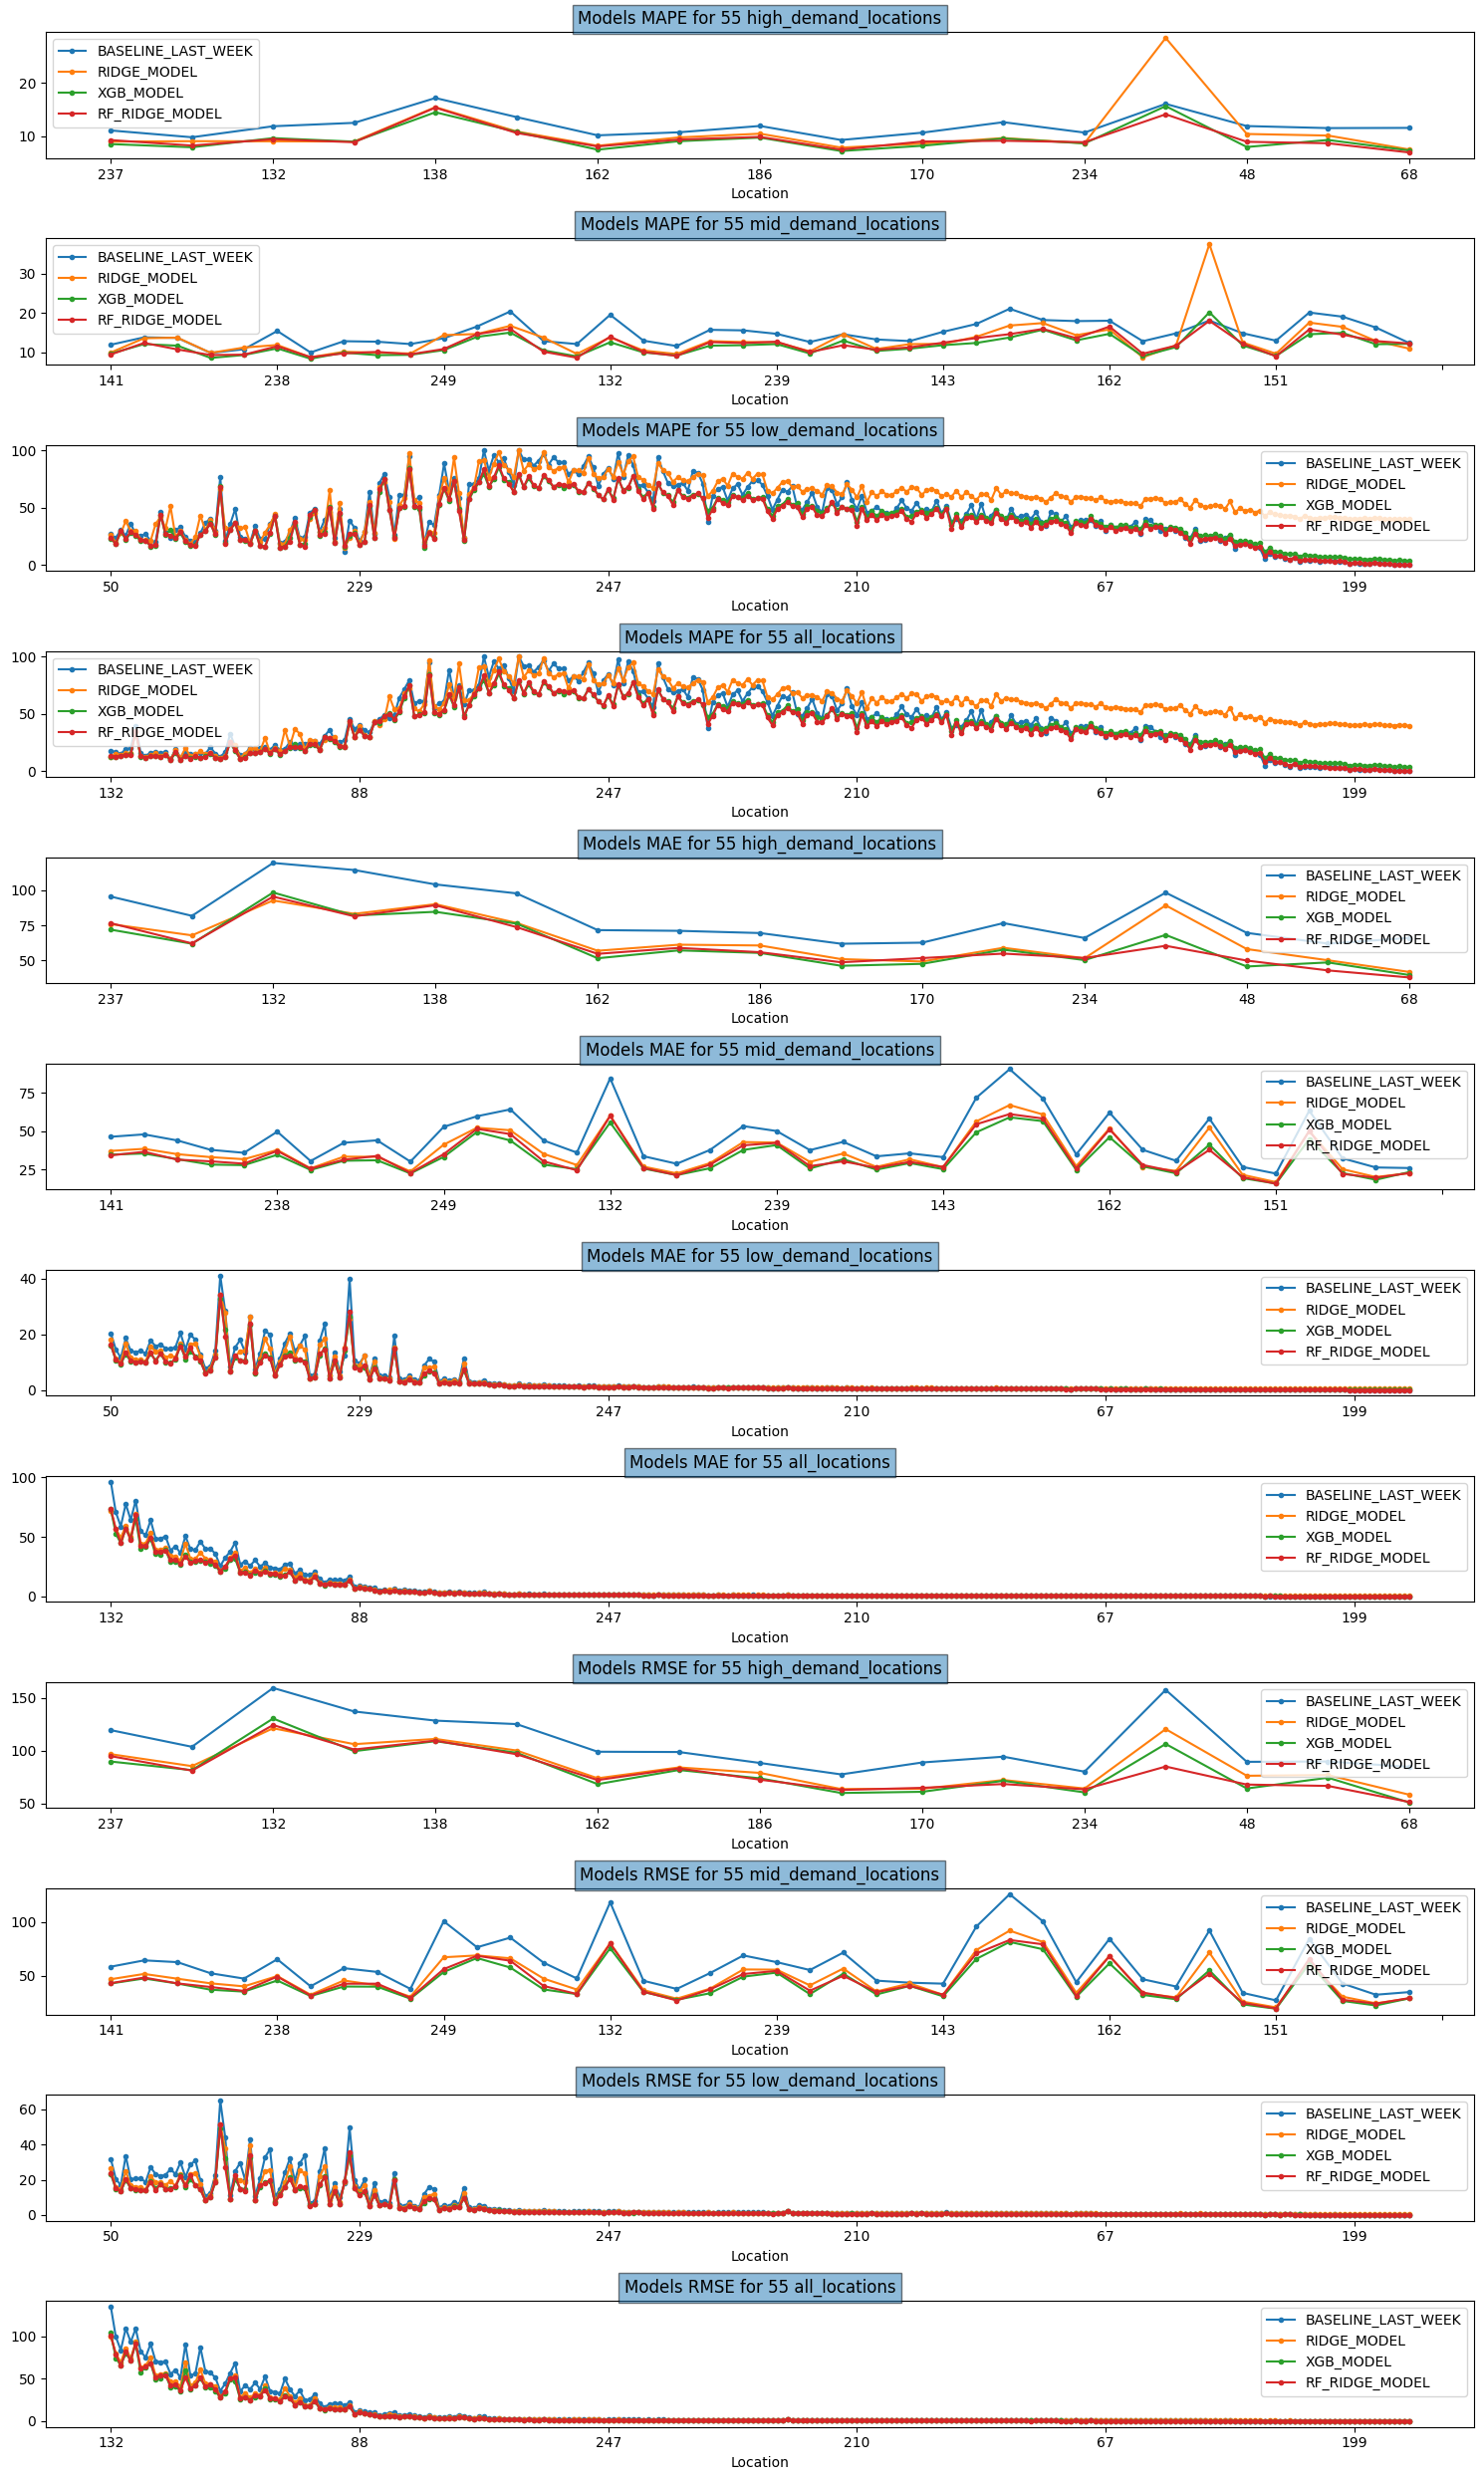

In [30]:
plot(predictions_mean_error_dict, 'Location')

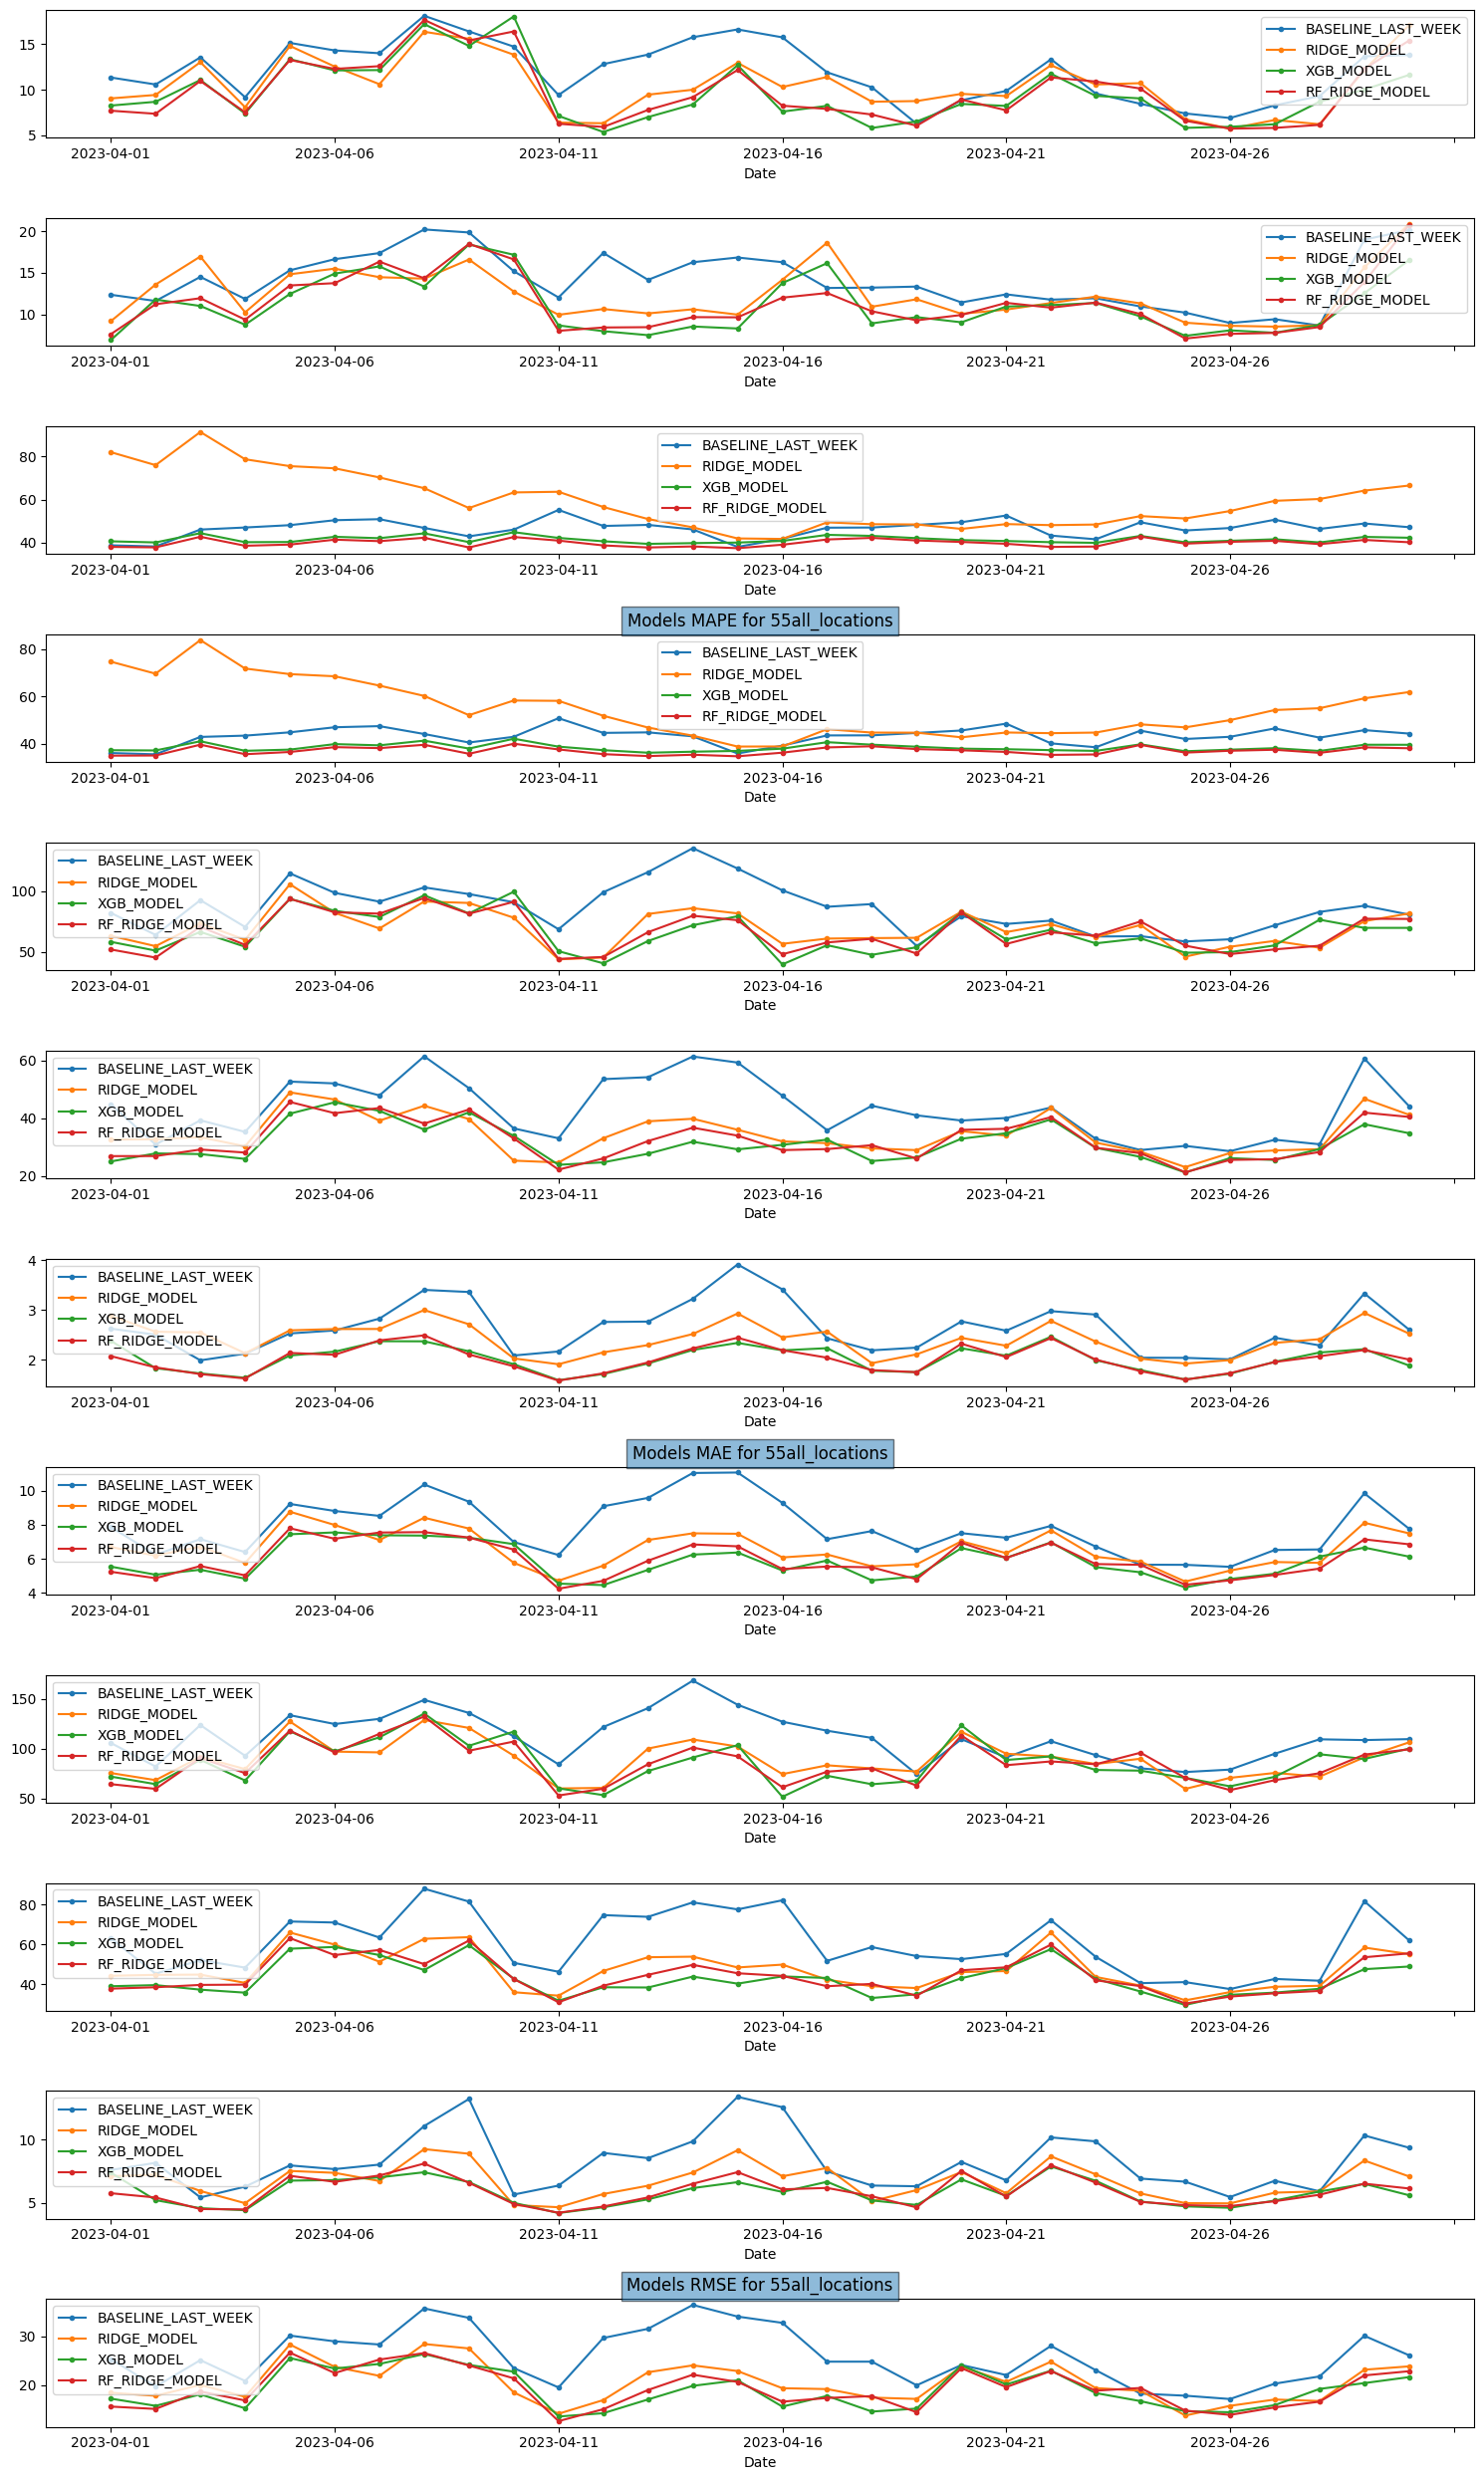

In [20]:
plot(predictions_mean_error_dict, 'Date')

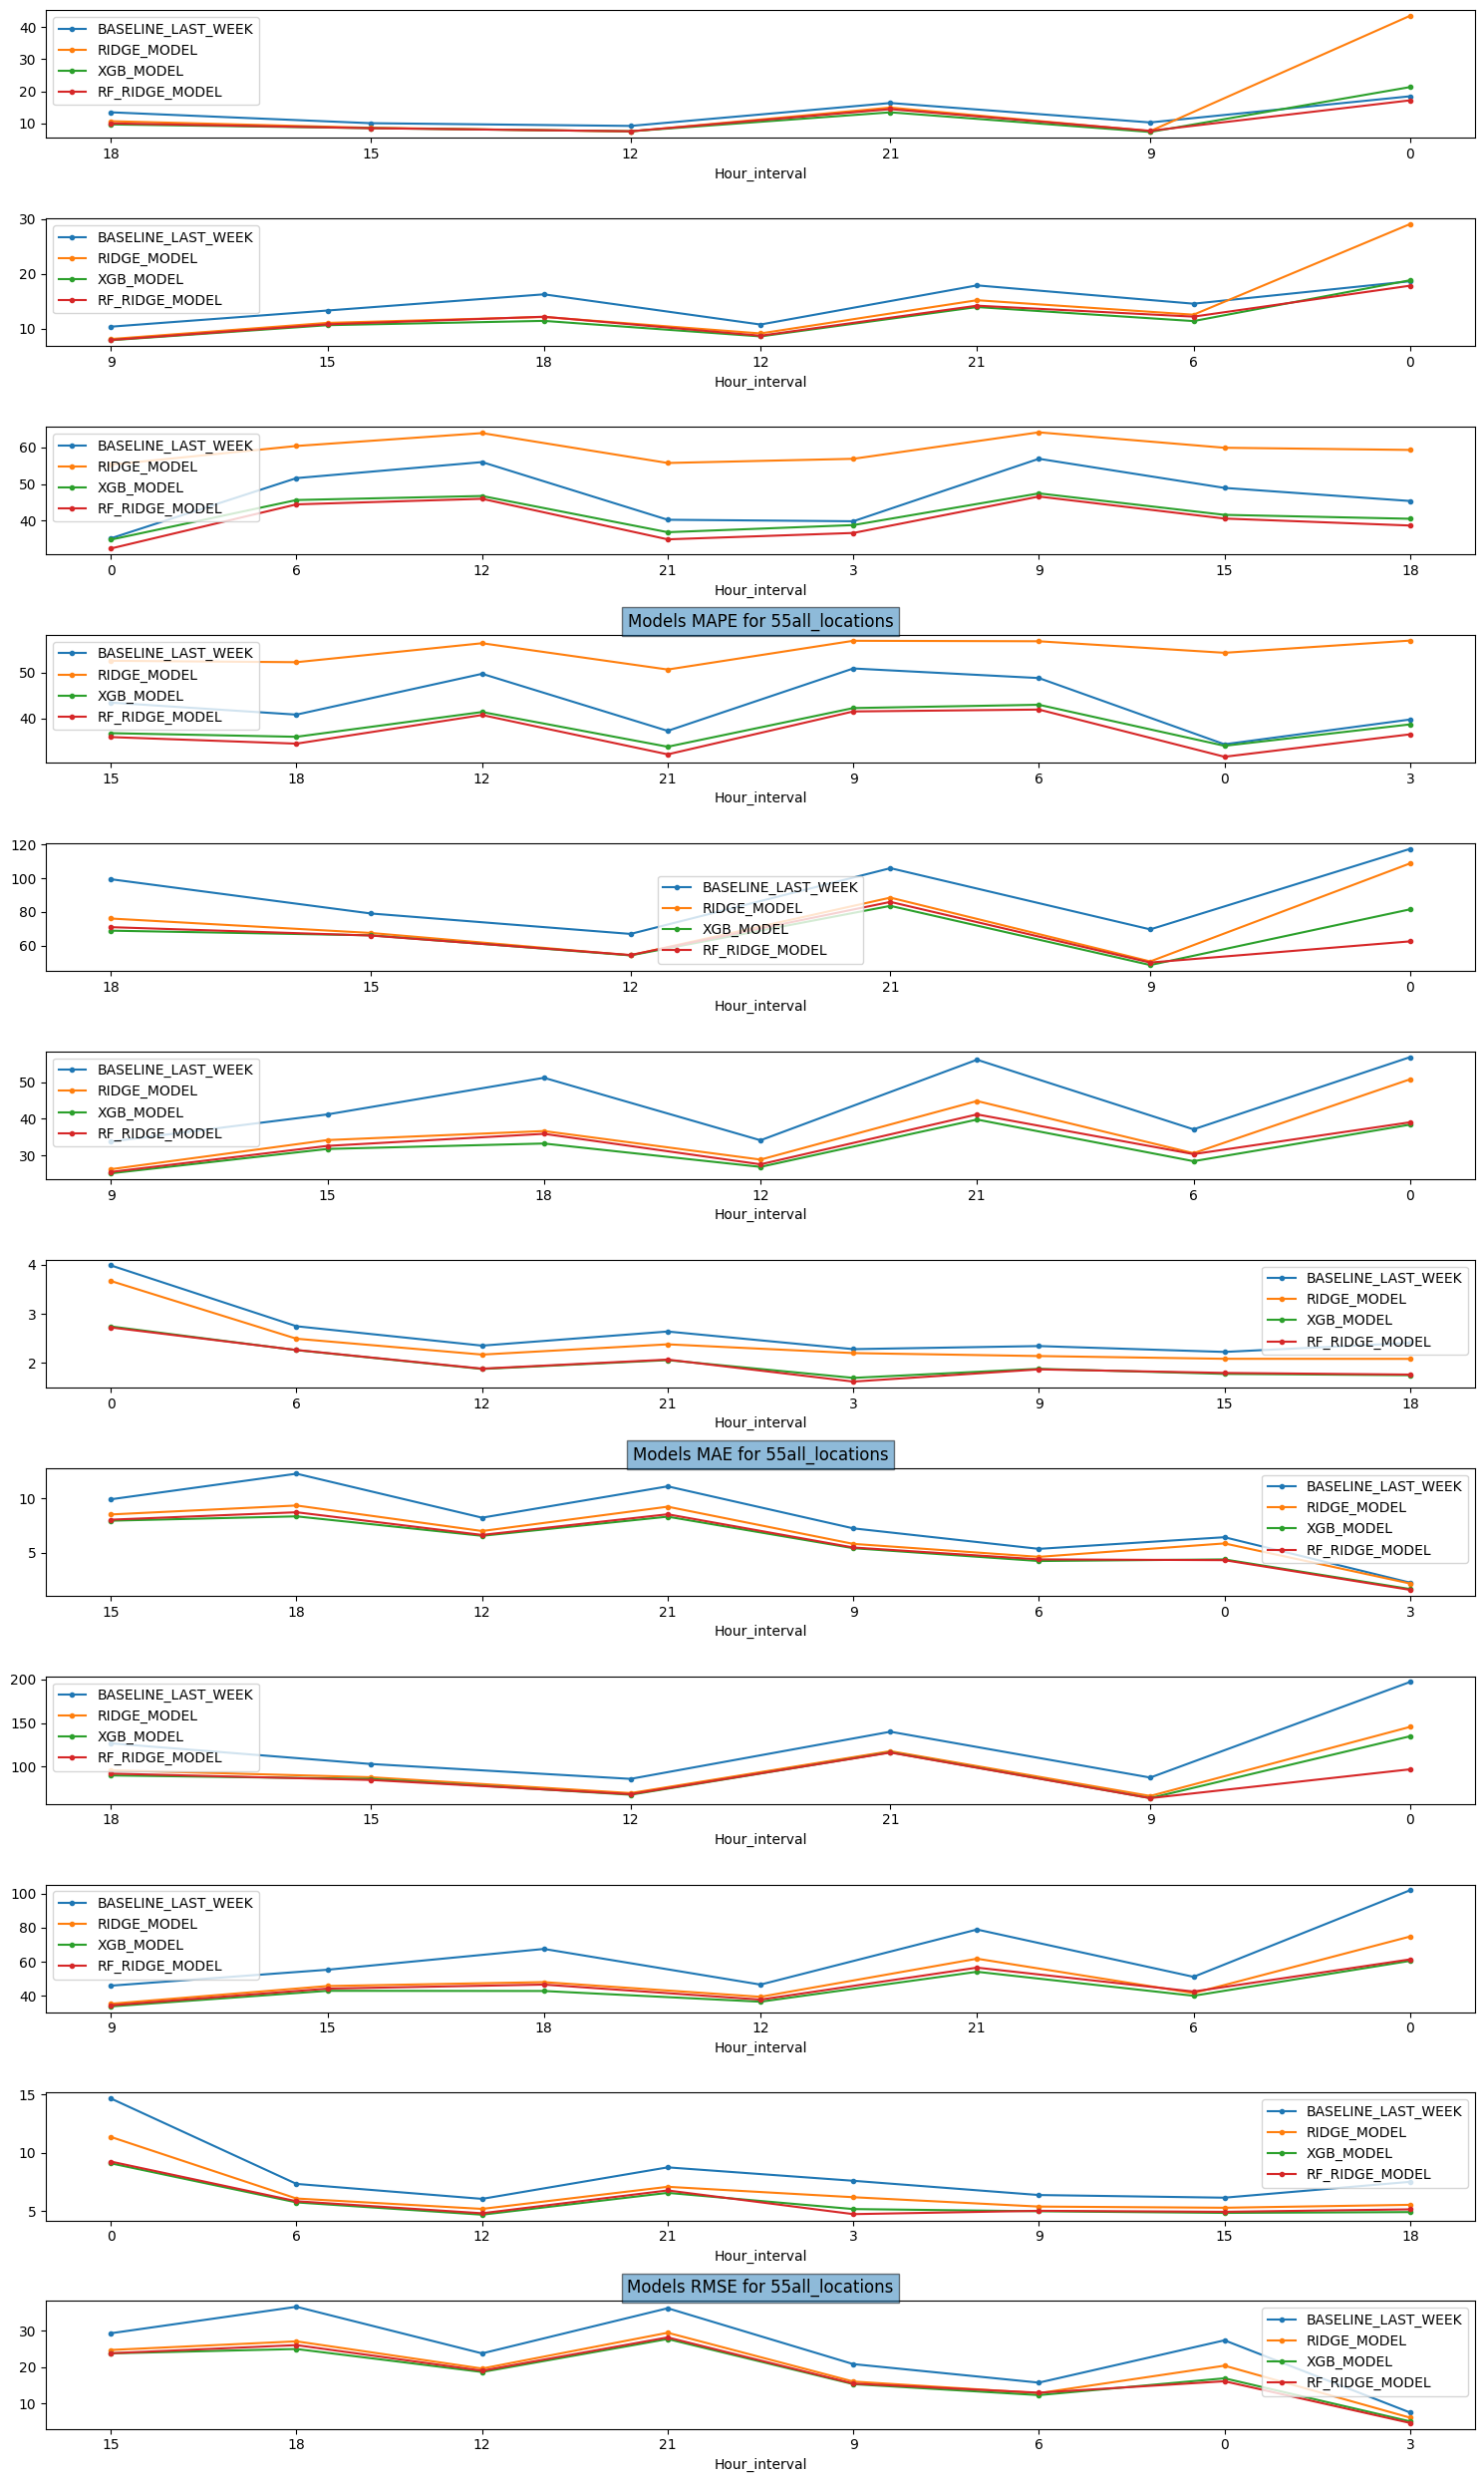

In [21]:
plot(predictions_mean_error_dict, 'Hour_interval')

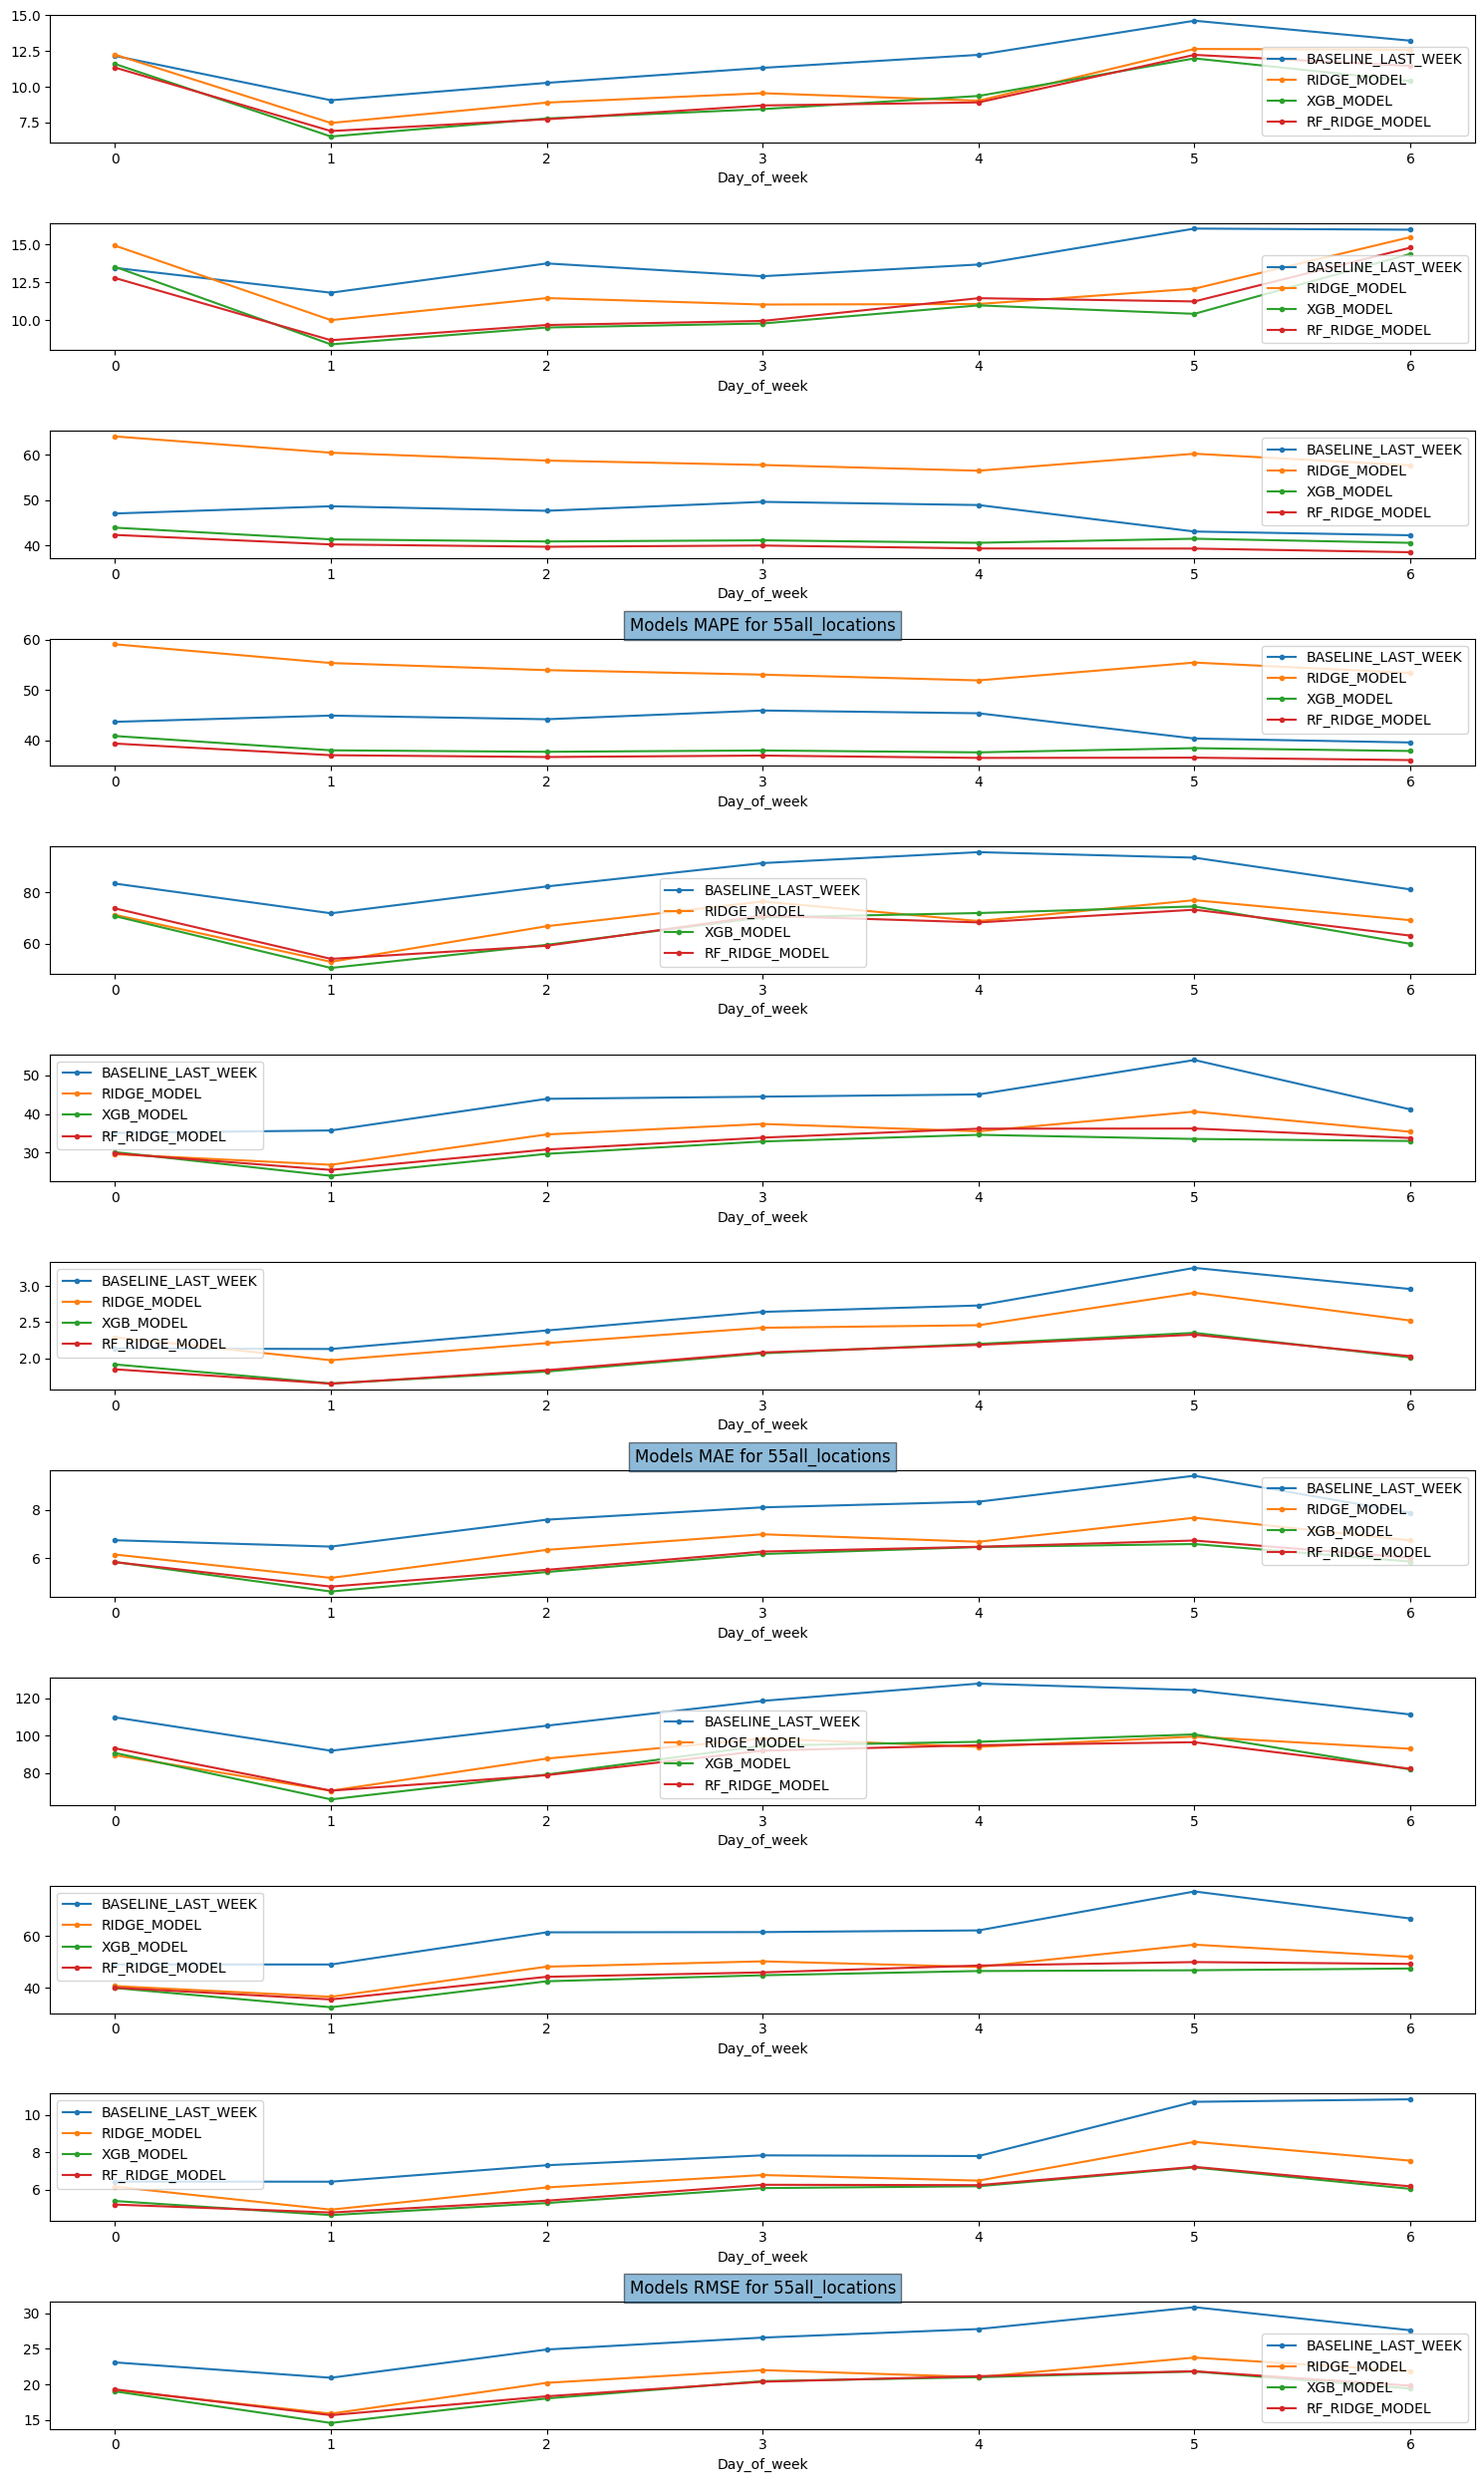

In [22]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [23]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['Location', 'Hour_interval']]
                categorized_df = error_df.merge(sorted_index, on=['Location','Hour_interval'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [24]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [25]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES,
                                                      METRICS], names=['location CATEGORIES:', 'Error Metrics:']))


In [26]:
df.style.format('{:.2f}')